# Vision transformer


## Import libraries

In [3]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from attention_mnist_utils import (
    image_to_patches,
    train,
    MLP,
    evaluate_classification,
)
from IPython.display import clear_output

## Setting some parameters

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Downloading MNIST from torchvision

In [6]:
# set the preprocess operations to be performed on train/val/test samples
preprocessing_transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(
    root="./data/torchvision/MNIST/training",
    train=True,
    download=True,
    transform=preprocessing_transformation,
)
train_set, test_set = torch.utils.data.random_split(train_dataset, [1000, 59000])

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=32, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=True)

Let's check that we have the correct number of samples in our dataloader

In [7]:
len(train_loader.dataset), len(test_loader.dataset)

(1000, 59000)

Let's see how many batches we have in the dataloader

In [8]:
len(train_loader), len(test_loader)

(32, 1844)

Let's pick four example images

In [9]:
n_images = 4
examples_imgs = torch.stack([test_set[idx][0] for idx in range(n_images)], dim=0)

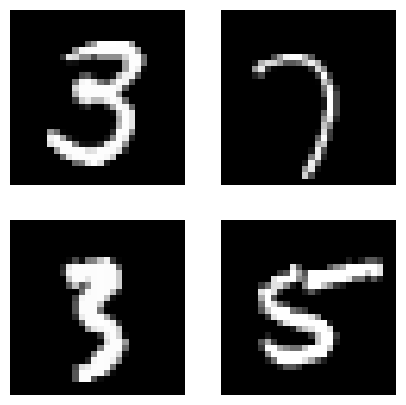

In [10]:
plt.figure(figsize=(5, 5))
for i in range(n_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(examples_imgs[i, 0], cmap="gray")
    plt.axis("off")
plt.show()

### Visualizing `image_to_patches` function

We first transform the four examples images to patches.

In [11]:
# image size in one dimension (whole image is of shape (image_size , image_size)
image_size = 28

# patch size in one dimension (whole patch is of shape (patch_size , patch_size)
patch_size = 4

# total number of patches, here 7^2 = 49
num_patches = int((image_size / patch_size) ** 2)

In [12]:
img_patches = image_to_patches(examples_imgs, patch_size=patch_size)
img_patches.shape

torch.Size([4, 49, 16])

This shape corresponds to 4 images with 49 (7x7) patches, each consisting of 16 pixels (4x4). For the model, this shape is fine, but for visualizing the patched image we need to reshape it.

In [13]:
num_patch_per_dim = int(np.sqrt(num_patches))

In [14]:
image = img_patches[1].reshape(7, 7, 4, 4) 
#[1]:second image, (7,7,4,4):4-d array,7x7:49 grid,4x4 pix

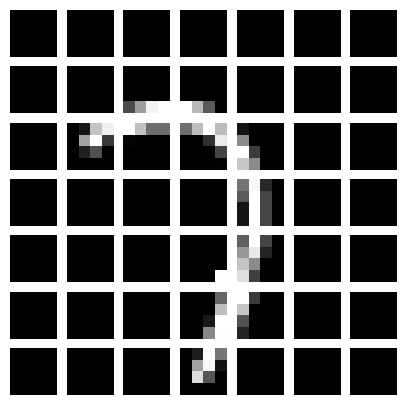

In [15]:
plt.figure(figsize=(5, 5))
k = 0
for i in range(num_patch_per_dim):
    for j in range(num_patch_per_dim):
        k += 1

        plt.subplot(num_patch_per_dim, num_patch_per_dim, k)
        plt.imshow(image[i, j], cmap="gray")
        plt.axis("off")

## VisionTransformer class

In [16]:
# Scaled dot prod
class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model #size of the feature dim for i/p space
        self.scale = 1.0 / (d_model**0.5) #scaling factor in d(x)

        # Define linear layers for queries, keys, and values
        self.query_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)
        self.key_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)
        self.value_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)

    def forward(self, queries, keys, values):
        """
        Args:
            keys: tensor of shape (batch_size, d_seq, d_model)
            queries: tensor of shape (batch_size, d_seq, d_model)
            values: tensor of shape (batch_size, d_seq, d_model)

        Returns:
            context: tensor of shape (batch_size, d_seq, d_model)
        """
        # Project x to query, key, and value
        query = self.query_linear(queries)  # shape: (batch_size, d_seq, d_model)
        key = self.key_linear(keys)  # shape: (batch_size, d_seq, d_model)
        value = self.value_linear(values)  # shape: (batch_size, d_seq, d_model)
        #we're transforming the Q.K.V into a linear layers or matrices
        
        # Compute scaled dot product
        attn_logits = torch.matmul(query, key.transpose(-2, -1)) * self.scale
        # Compute attention weights
        attn_weights = F.softmax(attn_logits, dim=-1)
        attention = torch.matmul(attn_weights, value)  # shape: (batch_size, d_seq, d_model)

        return attention

In [17]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model):
        """
        Inputs:
            d_model - Feature dimension
        """
        super().__init__()
        #self-attention layer
        self.self_attention = ScaledDotProductAttention(d_model) 
        
        #MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * 4),  # Expand dimensionality
            nn.ReLU(),                        # Non-linearity
            nn.Linear(d_model * 4, d_model)   # Project back to d_model
        )

    def forward(self, x):
        """
        Args:
            x: tensor of shape (batch_size, d_seq, d_model)
        
        Returns:
            Updated tensor of the same shape
        """
        #Residual attention update steps
        attention = self.self_attention(x, x, x)
        x = x + attention

        # Residual MLP update
        x = x + self.mlp(x)
        return x

In [18]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        d_model,
        num_layers,
        num_classes,
        patch_size,
    ):
        """
        Inputs:
            d_model - Dimensionality of the input feature vectors to the Transformer
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
        """
        super().__init__()

        self.patch_size = patch_size

        # Linear embedding for patches
        self.linear_in = nn.Linear(patch_size * patch_size, d_model)

        # Transformer layers
        self.transformer = nn.Sequential(
            *(SelfAttentionBlock(d_model) for _ in range(num_layers))
        )

        # Classification head
        self.linear_out = nn.Linear(d_model, num_classes)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))

    def forward(self, x):
        # Image to patches
        x = image_to_patches(x, self.patch_size)

        # Embed patches
        x = self.linear_in(x)  # x.shape ---> n_samples, n_patches, d_model

        n_samples, _, _ = x.shape

        # Concatenate the class token with the patch features
        cls_token = self.class_token.repeat(n_samples, 1, 1)
        x = torch.cat(
            [cls_token, x], dim=1
        )  # x.shape ---> (n_samples,n_patches+1, d_model)

        # Transformer update
        x = self.transformer(x)

        # Perform classification prediction
        class_features = x[:, 0, :]  # Use the class token output

        class_prediction = self.linear_out(class_features)
        return class_prediction


## Initializing the model

We use the following hyperparameters for our model.

In [19]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
# Initialize the model with simpler parameters for a faster check
model = VisionTransformer(
    d_model=64,  # Reduced model dimension for faster testing
    num_classes=10,  # For MNIST classification
    num_layers=3,  # Reduced number of layers for quicker training
    patch_size=7,  # Patch size that divides 28x28 input dimensions evenly
)

# Transfer model to the correct device
model.to(device)

# Optimizer with a different learning rate if needed
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()


Train Epoch: 10, Loss: 0.519801
Train Epoch: 20, Loss: 0.245140
Train Epoch: 30, Loss: 0.010318
Train Epoch: 40, Loss: 0.000978
Train Epoch: 50, Loss: 0.000465


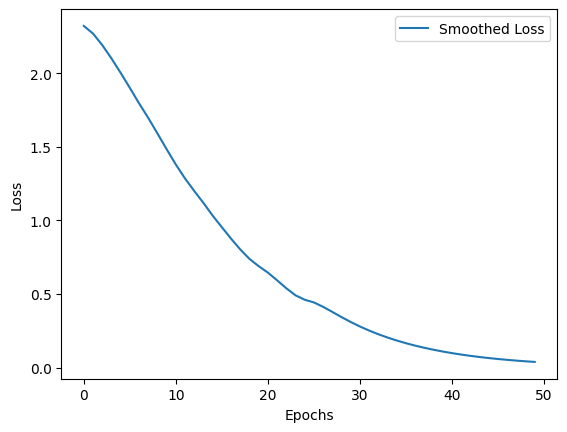

In [21]:
# Training loop with loss smoothing and adjustments
NUM_EPOCHS = 50
losses = []
log_interval = 10
smoothing_factor = 0.9  # Factor for smoothing the loss

# Smoothing function for losses
def smooth_loss(losses, smoothing_factor=0.9):
    smoothed_loss = []
    for i, loss in enumerate(losses):
        if i == 0:
            smoothed_loss.append(loss)
        else:
            smoothed_loss.append(smoothing_factor * smoothed_loss[i-1] + (1 - smoothing_factor) * loss)
    return smoothed_loss

for epoch in range(1, NUM_EPOCHS + 1):
    # Assuming train function returns a scalar loss value for each epoch
    loss = train(model, train_loader, optimizer, loss_fn, device)  # Ensure this returns scalar loss
    losses.append(loss)  # Append loss to the losses list

    if epoch % log_interval == 0:
        print(f"Train Epoch: {epoch}, Loss: {loss:.6f}")

# Smooth the losses for visualization
smoothed_losses = smooth_loss(losses, smoothing_factor)

# Plot the smoothed loss
plt.plot(smoothed_losses, label="Smoothed Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [22]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {count_parameters(model)}")

def evaluate_classification(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Evaluate the model
accuracy = evaluate_classification(model, criterion, test_loader, device)
if isinstance(accuracy, tuple):
    accuracy = accuracy[0]

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Trainable parameters: 140618
Test Accuracy: 70.29%


## Training

## Picking one test sample and running it through the first attention block

We can compute the attention by embedding the data and the manually computing the map.

#### Here I called A*V instead of just A = attention weight

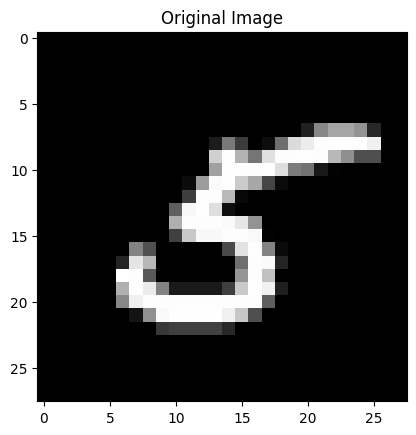

Shape of image: torch.Size([1, 28, 28])
Shape of patches: torch.Size([1, 16, 49])
Shape of embedded patches: torch.Size([1, 16, 64])
Shape of concatenated input: torch.Size([1, 17, 64])
Shape of attention weights: torch.Size([1, 17, 64])


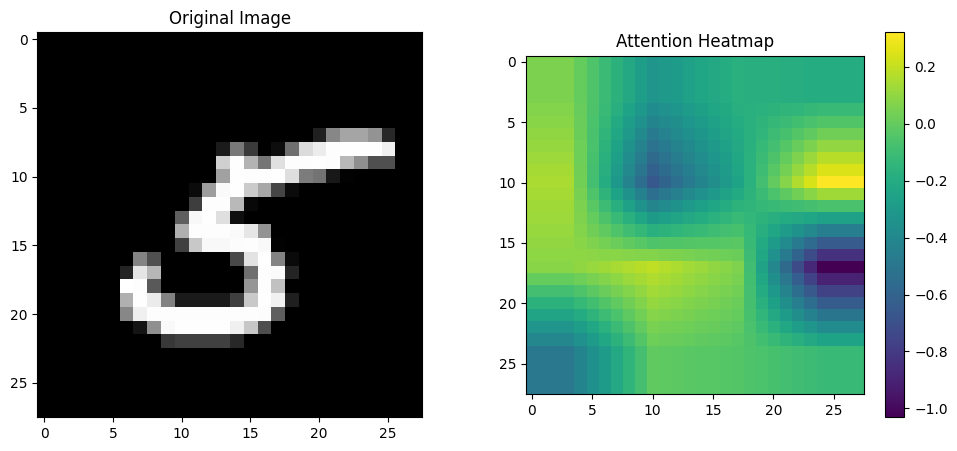

In [ ]:
# Picking a test sample (accessing the underlying dataset targets)
test_sample_index = (test_set.dataset.targets == 5).nonzero(as_tuple=True)[0][10].item()

# Pull out one test sample
image = test_set.dataset[test_sample_index][0][0].unsqueeze(0).to(device)  # Add batch dimension
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Original Image")
plt.show()

# Compute the attention by embedding the data and manually computing the map
patch_size = model.patch_size  # Ensure patch size is defined in the model

# Validate patch size
if 28 % patch_size != 0:
    raise ValueError(f"Patch size {patch_size} does not evenly divide image dimensions (28x28).")

# Split the image into patches and embed them
x = image_to_patches(image.reshape(1, 1, 28, 28), patch_size)
x_embedded = model.linear_in(x)

# Add the class token, so that we know exactly where the info is taken fm n tokenise
class_token = model.class_token.repeat(1, 1, 1)
x_cat = torch.cat([class_token, x_embedded], dim=1)

# Define queries and keys
queries = x_cat
keys = x_cat

# Compute attention weights, we are getting weights here
#instead of query and keys from model.transformer
weights = model.transformer[0].self_attention(queries, keys, x_cat)

# Verify the shapes of intermediate tensors
print(f"Shape of image: {image.shape}")
print(f"Shape of patches: {x.shape}")
print(f"Shape of embedded patches: {x_embedded.shape}")
print(f"Shape of concatenated input: {x_cat.shape}")
print(f"Shape of attention weights: {weights.shape}")

# Compute the number of patches
num_patches = x_embedded.shape[1]  # Number of patches in the embedded image

# Attempt to compute the number of patches per dimension
num_patches_per_dim = int(num_patches ** 0.5)
if num_patches_per_dim ** 2 != num_patches:
    print(f"Warning: Number of patches is not a perfect square.")
    # Compute approximate dimensions
    num_patches_h = num_patches_w = int(torch.ceil(torch.sqrt(torch.tensor(num_patches))).item())
    print(f"Approximating dimensions: {num_patches_h}x{num_patches_w}")
else:
    num_patches_h = num_patches_w = num_patches_per_dim

# Compute attention map excluding the class token attention
attn_map = weights[0, 0, 1:num_patches + 1]

# Handle cases where the attention map size doesn't match the approximated dimensions
if attn_map.numel() != num_patches_h * num_patches_w:
    attn_map = attn_map[:num_patches_h * num_patches_w]  # Truncate excess patches

attn_map = attn_map.view(num_patches_h, num_patches_w)
#Attention map(A*V) is completely called instead of just Attention weight A here.
#A just has Q,W and soft max for (matmul of Q,W)

# Resize attention map to 28x28 pixels for visualization
attn_heatmap_resized = F.interpolate(
    attn_map.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
    size=(28, 28),
    mode="bilinear",
).squeeze()  # Remove extra dimensions

# Plot the attention heatmap alongside the original image
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Original Image")

# Attention Heatmap
plt.subplot(1, 2, 2)
plt.imshow(attn_heatmap_resized.cpu().detach().numpy(), cmap='viridis')
plt.title("Attention Heatmap")
plt.colorbar()

plt.show()


### Here I changed to call just A

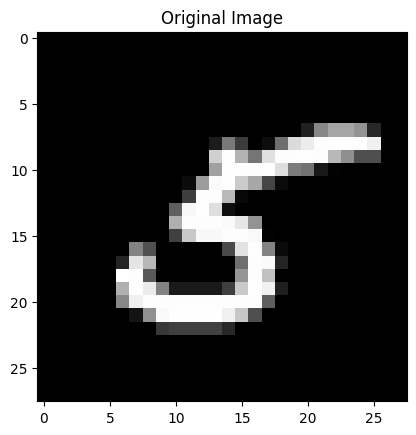

Shape of image: torch.Size([1, 28, 28])
Shape of patches: torch.Size([1, 16, 49])
Shape of embedded patches: torch.Size([1, 16, 64])
Shape of concatenated input: torch.Size([1, 17, 64])
Shape of attention weights: torch.Size([1, 17, 17])
Shape of class token weights: torch.Size([16])


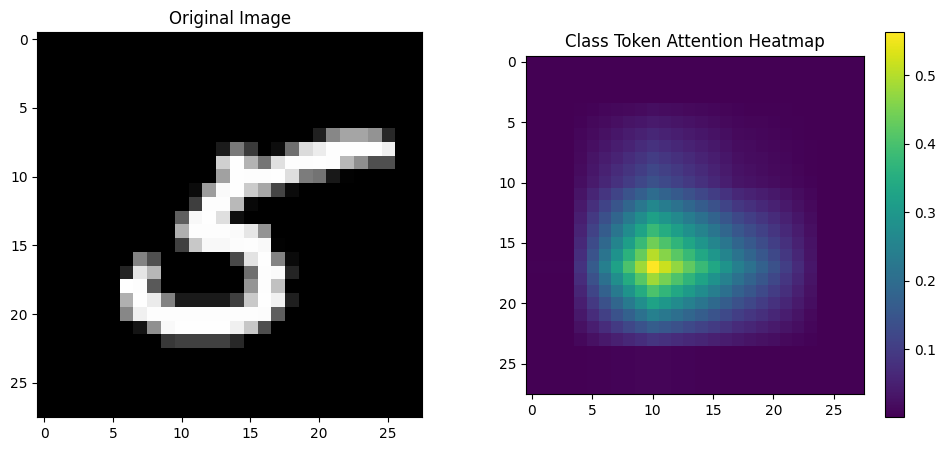

In [34]:
# Picking a test sample (accessing the underlying dataset targets)
test_sample_index = (test_set.dataset.targets == 5).nonzero(as_tuple=True)[0][10].item()

# Pull out one test sample
image = test_set.dataset[test_sample_index][0][0].unsqueeze(0).to(device)  # Add batch dimension
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Original Image")
plt.show()

# Compute the attention by embedding the data and manually computing the map
patch_size = model.patch_size  # Ensure patch size is defined in the model

# Validate patch size
if 28 % patch_size != 0:
    raise ValueError(f"Patch size {patch_size} does not evenly divide image dimensions (28x28).")

# Split the image into patches and embed them
x = image_to_patches(image.reshape(1, 1, 28, 28), patch_size)
x_embedded = model.linear_in(x)

# Add the class token
class_token = model.class_token.repeat(1, 1, 1)
x_cat = torch.cat([class_token, x_embedded], dim=1)

# Compute attention weights manually (focus on A, not A * V)
queries = x_cat  # Use the concatenated input as queries
keys = x_cat  # Use the concatenated input as keys

# Pass through linear layers for query and key
query = model.transformer[0].self_attention.query_linear(queries)  # Shape: (batch_size, num_patches+1, d_model)
key = model.transformer[0].self_attention.key_linear(keys)  # Shape: (batch_size, num_patches+1, d_model)

# Compute scaled dot-product attention logits
d_k = query.size(-1)  # Dimensionality of the query/key vectors
attn_logits = torch.matmul(query, key.transpose(-2, -1)) / (d_k**0.5)  # Shape: (batch_size, num_patches+1, num_patches+1)

# Apply softmax to get attention weights
attn_weights = F.softmax(attn_logits, dim=-1)  # Shape: (batch_size, num_patches+1, num_patches+1)

# Extract attention weights for the class token
class_token_weights = attn_weights[0, 0, 1:]  # Exclude the class token's self-attention

# Verify the shapes of intermediate tensors
print(f"Shape of image: {image.shape}")
print(f"Shape of patches: {x.shape}")
print(f"Shape of embedded patches: {x_embedded.shape}")
print(f"Shape of concatenated input: {x_cat.shape}")
print(f"Shape of attention weights: {attn_weights.shape}")
print(f"Shape of class token weights: {class_token_weights.shape}")

# Compute the number of patches
num_patches = x_embedded.shape[1]  # Number of patches in the embedded image

# Attempt to compute the number of patches per dimension
num_patches_per_dim = int(num_patches ** 0.5)
if num_patches_per_dim ** 2 != num_patches:
    print(f"Warning: Number of patches is not a perfect square.")
    # Compute approximate dimensions
    num_patches_h = num_patches_w = int(torch.ceil(torch.sqrt(torch.tensor(num_patches))).item())
    print(f"Approximating dimensions: {num_patches_h}x{num_patches_w}")
else:
    num_patches_h = num_patches_w = num_patches_per_dim

# Reshape attention weights to match the grid of patches
attn_map = class_token_weights.view(num_patches_h, num_patches_w)

# Resize attention map to 28x28 pixels for visualization
attn_heatmap_resized = F.interpolate(
    attn_map.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
    size=(28, 28),
    mode="bilinear",
).squeeze()  # Remove extra dimensions

# Plot the attention heatmap alongside the original image
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Original Image")

# Attention Heatmap
plt.subplot(1, 2, 2)
plt.imshow(attn_heatmap_resized.cpu().detach().numpy(), cmap='viridis')
plt.title("Class Token Attention Heatmap")
plt.colorbar()

plt.show()
